<p align="center">
<img src="https://github.com/datacamp/r-live-training-template/blob/master/assets/datacamp.svg?raw=True" alt = "DataCamp icon" width="50%">
<br>
<h1 align="center"><b>Cleaning Data in R Live Training</b></h1>
</p>
<br>


Welcome to this hands-on training where you'll identify issues in a dataset and clean it from start to finish using R. It's often said that data scientists spend 80% of their time cleaning and manipulating data and only about 20% of their time analyzing it, so cleaning data is an important skill to master!

In this session, you will:

- Examine a dataset and identify its problem areas, and what needs to be done to fix them.
-Convert between data types to make analysis easier.
- Correct inconsistencies in categorical data.
- Deal with missing data.
- Perform data validation to ensure every value makes sense.

## **The Dataset**

The dataset we'll use is a CSV file named `nyc_airbnb.csv`, which contains data on [*Airbnb*](https://www.airbnb.com/) listings in New York City. It contains the following columns:

- `listing_id`: The unique identifier for a listing
- `name`: The description used on the listing
- `host_id`: Unique identifier for a host
- `host_name`: Name of host
- `nbhood_full`: Name of borough and neighborhood
- `coordinates`: Coordinates of listing _(latitude, longitude)_
- `room_type`: Type of room 
- `price`: Price per night for listing
- `nb_reviews`: Number of reviews received 
- `last_review`: Date of last review
- `reviews_per_month`: Average number of reviews per month
- `availability_365`: Number of days available per year
- `avg_rating`: Average rating (from 0 to 5)
- `avg_stays_per_month`: Average number of stays per month
- `pct_5_stars`: Percent of reviews that were 5-stars
- `listing_added`: Date when listing was added


In [1]:
# Install non-tidyverse packages
install.packages("visdat")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# Load packages
library(readr)
library(dplyr)
library(stringr)
library(visdat)
library(tidyr)
library(ggplot2)
library(forcats)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# Load dataset
airbnb <- read_csv("https://raw.githubusercontent.com/datacamp/cleaning-data-in-r-live-training/master/assets/nyc_airbnb.csv")

Parsed with column specification:
cols(
  listing_id = col_double(),
  description = col_character(),
  host_id = col_double(),
  host_name = col_character(),
  nbhood_full = col_character(),
  coordinates = col_character(),
  room_type = col_character(),
  price = col_character(),
  nb_reviews = col_double(),
  last_review = col_character(),
  reviews_per_month = col_double(),
  availability_365 = col_double(),
  avg_rating = col_double(),
  avg_stays_per_month = col_double(),
  pct_5_stars = col_double(),
  listing_added = col_character()
)



In [4]:
# Examine the first few rows
head(airbnb)

listing_id,description,host_id,host_name,nbhood_full,coordinates,room_type,price,nb_reviews,last_review,reviews_per_month,availability_365,avg_rating,avg_stays_per_month,pct_5_stars,listing_added
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
13740704,"Cozy,budget friendly, cable inc, private entrance!",20583125,Michel,"Brooklyn, Flatlands","(40.63222, -73.93398)",Private room,$45,10,12/12/2018,0.70,85,4.100954,12.0,0.6094315,06/08/2018
22005115,Two floor apartment near Central Park,82746113,Cecilia,"Manhattan, Upper West Side","(40.78761, -73.96862)",Entire home/apt,$135,1,06/30/2019,1.00,145,3.367600,1.2,0.7461346,12/25/2018
21667615,Beautiful 1BR in Brooklyn Heights,78251,Leslie,"Brooklyn, Brooklyn Heights","(40.7007, -73.99517)",Entire home/apt,$150,0,NA,NA,65,NA,NA,NA,08/15/2018
6425850,"Spacious, charming studio",32715865,Yelena,"Manhattan, Upper West Side","(40.79169, -73.97498)",Entire home/apt,$86,5,09/23/2017,0.13,0,4.763203,6.0,0.7699471,03/20/2017
22986519,Bedroom on the lively Lower East Side,154262349,Brooke,"Manhattan, Lower East Side","(40.71884, -73.98354)",Private room,$160,23,06/12/2019,2.29,102,3.822591,27.6,0.6493831,10/23/2020
271954,Beautiful brownstone apartment,1423798,Aj,"Manhattan, Greenwich Village","(40.73388, -73.99452)",Entire home/apt,$150,203,06/20/2019,2.22,300,4.478396,243.6,0.7434997,12/15/2018


## **Diagnosing data cleaning problems**


We'll need to get a good look at the data frame in order to identify any problems that may cause issues during an analysis. There are a variety of functions (both from base R and `dplyr`) that can help us with this:

-  `head()` to look at the first few rows of the data
- `glimpse()` to get a summary of the variables' data types
- `summary()` to compute summary statistics of each variable and display the number of missing values
- `duplicated()` to find duplicates


In [5]:
# Print the first few rows of data
head(airbnb)

listing_id,description,host_id,host_name,nbhood_full,coordinates,room_type,price,nb_reviews,last_review,reviews_per_month,availability_365,avg_rating,avg_stays_per_month,pct_5_stars,listing_added
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
13740704,"Cozy,budget friendly, cable inc, private entrance!",20583125,Michel,"Brooklyn, Flatlands","(40.63222, -73.93398)",Private room,$45,10,12/12/2018,0.70,85,4.100954,12.0,0.6094315,06/08/2018
22005115,Two floor apartment near Central Park,82746113,Cecilia,"Manhattan, Upper West Side","(40.78761, -73.96862)",Entire home/apt,$135,1,06/30/2019,1.00,145,3.367600,1.2,0.7461346,12/25/2018
21667615,Beautiful 1BR in Brooklyn Heights,78251,Leslie,"Brooklyn, Brooklyn Heights","(40.7007, -73.99517)",Entire home/apt,$150,0,NA,NA,65,NA,NA,NA,08/15/2018
6425850,"Spacious, charming studio",32715865,Yelena,"Manhattan, Upper West Side","(40.79169, -73.97498)",Entire home/apt,$86,5,09/23/2017,0.13,0,4.763203,6.0,0.7699471,03/20/2017
22986519,Bedroom on the lively Lower East Side,154262349,Brooke,"Manhattan, Lower East Side","(40.71884, -73.98354)",Private room,$160,23,06/12/2019,2.29,102,3.822591,27.6,0.6493831,10/23/2020
271954,Beautiful brownstone apartment,1423798,Aj,"Manhattan, Greenwich Village","(40.73388, -73.99452)",Entire home/apt,$150,203,06/20/2019,2.22,300,4.478396,243.6,0.7434997,12/15/2018


- **Observation 1:** The `coordinates` column contains multiple pieces of information: both latitude and longitude.
- **Observation 2:** The `price` column is formatted with an unnecessary `$`.

In [6]:
# Inspect data types
glimpse(airbnb)

Rows: 10,019
Columns: 16
$ listing_id          <dbl> 13740704, 22005115, 21667615, 6425850, 22986519, …
$ description         <chr> "Cozy,budget friendly, cable inc, private entranc…
$ host_id             <dbl> 20583125, 82746113, 78251, 32715865, 154262349, 1…
$ host_name           <chr> "Michel", "Cecilia", "Leslie", "Yelena", "Brooke"…
$ nbhood_full         <chr> "Brooklyn, Flatlands", "Manhattan, Upper West Sid…
$ coordinates         <chr> "(40.63222, -73.93398)", "(40.78761, -73.96862)",…
$ room_type           <chr> "Private room", "Entire home/apt", "Entire home/a…
$ price               <chr> "$45", "$135", "$150", "$86", "$160", "$150", "$2…
$ nb_reviews          <dbl> 10, 1, 0, 5, 23, 203, 0, 2, 5, 8, 5, 2, 21, 0, 0,…
$ last_review         <chr> "12/12/2018", "06/30/2019", NA, "09/23/2017", "06…
$ reviews_per_month   <dbl> 0.70, 1.00, NA, 0.13, 2.29, 2.22, NA, 0.08, 0.15,…
$ availability_365    <dbl> 85, 145, 65, 0, 102, 300, 219, 353, 365, 9, 0, 24…
$ avg_rating          <dbl>

- **Observation 3:** Columns like `coordinates` and `price` are factors instead of numeric values.
- **Observation 4:** Columns with dates like `last_review` and `listing_added` are factors instead of the `Date` data type.

In [7]:
# Examine summary statistics and missing values
summary(airbnb)

   listing_id       description           host_id           host_name        
 Min.   :    3831   Length:10019       Min.   :     2787   Length:10019      
 1st Qu.: 9674772   Class :character   1st Qu.:  7910880   Class :character  
 Median :20070296   Mode  :character   Median : 31651673   Mode  :character  
 Mean   :19276341                      Mean   : 67959227                     
 3rd Qu.:29338637                      3rd Qu.:107434423                     
 Max.   :36487245                      Max.   :274103383                     
                                                                             
 nbhood_full        coordinates         room_type            price          
 Length:10019       Length:10019       Length:10019       Length:10019      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                    

- **Observation 5:** There are 2075 missing values in `reviews_per_month`, `avg_rating`, `nb_stays`, and `pct_5_stars`.
- **Observation 6:** The max of `avg_rating` is above 5 (out of range value)
- **Observation 7:** There are inconsistencies in the categories of `room_type`, i.e. `"Private"`, `"Private room"`, and `"PRIVATE ROOM"`.

In [8]:
# Count data with duplicated listing_id
airbnb %>%
  filter(duplicated(listing_id)) %>%
  nrow()

[1] 20

*A note on the `%>%` operator:*

This is an operator commonly used in the Tidyverse to make code more readable. The `%>%` takes the result of whatever is before it and inserts it as the first argument in the subsequent function.

We could do this exact same counting operation using the following, but the function calls aren't in the order they're being executed, which makes it difficult to understand what's going on. The `%>%` allows us to write the functions in the order that they're executed.
```r
nrow(filter(airbnb, duplicated(listing_id)))
```

- **Observation 8:** There are 20 rows whose `listing_id` already appeared earlier in the dataset (duplicates).

## **What do we need to do?**

**Data type issues**
- **Task 1:** Split `coordinates` into latitude and longitude and convert `numeric` data type.
- **Task 2:** Remove `$`s from `price` column and convert to `numeric`.
- **Task 3:** Convert `last_review` and `listing_added` to `Date`.

**Text & categorical data issues**
- **Task 4:** Split `nbhood_full` into separate neighborhood and borough columns.
- **Task 5:** Collapse the categories of `room_type` so that they're consistent.

**Data range issues**
- **Task 6:** Fix the `avg_rating` column so it doesn't exceed `5`.

**Missing data issues**
- **Task 7:** Further investigate the missing data and decide how to handle them.

**Duplicate data issues**
- **Task 8:** Further investigate duplicate data points and decide how to handle them.

***But also...***
- We need to validate our data using various sanity checks

---
<center><h1><b>Q&A</b></h1></center>

---

## **Cleaning the data**


### **Data type issues**


In [9]:
# Reminder: what does the data look like?
head(airbnb)

listing_id,description,host_id,host_name,nbhood_full,coordinates,room_type,price,nb_reviews,last_review,reviews_per_month,availability_365,avg_rating,avg_stays_per_month,pct_5_stars,listing_added
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
13740704,"Cozy,budget friendly, cable inc, private entrance!",20583125,Michel,"Brooklyn, Flatlands","(40.63222, -73.93398)",Private room,$45,10,12/12/2018,0.70,85,4.100954,12.0,0.6094315,06/08/2018
22005115,Two floor apartment near Central Park,82746113,Cecilia,"Manhattan, Upper West Side","(40.78761, -73.96862)",Entire home/apt,$135,1,06/30/2019,1.00,145,3.367600,1.2,0.7461346,12/25/2018
21667615,Beautiful 1BR in Brooklyn Heights,78251,Leslie,"Brooklyn, Brooklyn Heights","(40.7007, -73.99517)",Entire home/apt,$150,0,NA,NA,65,NA,NA,NA,08/15/2018
6425850,"Spacious, charming studio",32715865,Yelena,"Manhattan, Upper West Side","(40.79169, -73.97498)",Entire home/apt,$86,5,09/23/2017,0.13,0,4.763203,6.0,0.7699471,03/20/2017
22986519,Bedroom on the lively Lower East Side,154262349,Brooke,"Manhattan, Lower East Side","(40.71884, -73.98354)",Private room,$160,23,06/12/2019,2.29,102,3.822591,27.6,0.6493831,10/23/2020
271954,Beautiful brownstone apartment,1423798,Aj,"Manhattan, Greenwich Village","(40.73388, -73.99452)",Entire home/apt,$150,203,06/20/2019,2.22,300,4.478396,243.6,0.7434997,12/15/2018


#### **Task 1:** Split `coordinates` into latitude and longitude and convert `numeric` data type.


- `str_remove_all()` removes all instances of a substring from a string.
- `str_split()` will split a string into multiple pieces based on a separation string.
- `as.data.frame()` converts an object into a data frame. It automatically converts any strings to `factor`s, which is not what we want in this case, so we'll stop this behavior using `stringsAsFactors = FALSE`.
- `rename()` takes arguments of the format `new_col_name = old_col_name` and renames the columns as such.

In [0]:
# Create lat_lon columns

lat_lon <- airbnb$coordinates %>%
  # Remove left parentheses
  str_remove_all(fixed("(")) %>%
  # Remove right parentheses
  str_remove_all(fixed(")")) %>%
  # Split latitude and longitude
  str_split(", ", simplify = TRUE) %>%
  # Convert from matrix to data frame
  as.data.frame(stringsAsFactors = FALSE) %>%
  # Rename columns
  rename(latitude = V1, longitude = V2)

- `cbind()` stands for column bind, which sticks two data frames together horizontally.

<img src="https://raw.githubusercontent.com/datacamp/cleaning-data-in-r-live-training/master/assets/cbind.png" width="500px;"/>

In [0]:
# Assign it to dataset

airbnb <- airbnb %>%
  # Combine lat_lon with original data frame
  cbind(lat_lon) %>%
  # Convert to numeric
  mutate(latitude = as.numeric(latitude),
        longitude = as.numeric(longitude)) %>%
  # Remove coordinates column
  select(-coordinates)

#### **Task 2:** Remove `$`s from `price` column and convert to `numeric`.

In [12]:
# Remove $ and convert to numeric
price_clean <- airbnb$price %>%
  str_remove_all(fixed("$")) %>%
  as.numeric()

Warning message in function_list[[k]](value):
“NAs introduced by coercion”


Notice we get a warning here that values are being converted to `NA`, so before we move on, we need to look into this further to ensure that the values are actually missing and we're not losing data by mistake.

Let's take a look at the values of `price`.


In [13]:
# Look at values of price
airbnb %>%
  count(price, sort = TRUE)

price,n
<chr>,<int>
$150,416
$100,395
$200,292
$50,287
$60,287
$75,281
$70,252
$80,241
$65,239


It looks like we have a non-standard representation of `NA` here, `$NA`, so these are getting coerced to `NA`s. This is the behavior we want, so we can ignore the warning.

In [0]:
# Add to data frame
airbnb <- airbnb %>%
  mutate(price = price_clean)

#### **Task 3:** Convert `last_review` and `listing_added` to `Date`.

Conversion to `Date` is done using `as.Date()`, which takes in a `format` argument. The `format` argument allows us to convert lots of different formats of dates to a `Date` type, like "January 1, 2020" or "01-01-2020". There are special symbols that we use to specify this. Here are a few of them, but you can find all the possible ones by typing `?strptime` into your console.

<img src="https://raw.githubusercontent.com/datacamp/cleaning-data-in-r-live-training/master/assets/date_formats.png" alt="%d = day number, %m = month number, %Y = 4 digit year, %y = 2 digit year, %B = month, %b = month abbreviation" width="250px;"/>

A date like "21 Oct 2020" would be in the format `"%d %b %Y"`.


In [0]:
# Look up date formatting symbols
?strptime

In [16]:
# Examine first rows of date columns
airbnb %>%
  select(last_review, listing_added) %>%
  head()

,last_review,listing_added
,<chr>,<chr>
1,12/12/2018,06/08/2018
2,06/30/2019,12/25/2018
3,NA,08/15/2018
4,09/23/2017,03/20/2017
5,06/12/2019,10/23/2020
6,06/20/2019,12/15/2018


In [0]:
# Convert strings to Dates
airbnb <- airbnb %>%
  mutate(last_review = as.Date(last_review, format = "%m/%d/%Y"),
        listing_added = as.Date(listing_added, format = "%m/%d/%Y"))

---
<center><h1><b>Q&A</b></h1></center>

---

### **Text & categorical data issues**


#### **Task 4:** Split `nbhood_full` into separate `nbhood` and `borough` columns.

In [0]:
# Split borough and neighborhood

borough_nbhood <- airbnb$nbhood_full %>%
  # Split column
  str_split(", ", simplify = TRUE) %>%
  # Convert from matrix to data frame
  as.data.frame() %>%
  # Rename columns
  rename(borough = V1, nbhood = V2)

In [0]:
# Assign to airbnb

airbnb <- airbnb %>%
  # Combine borough_nbhood with data
  cbind(borough_nbhood) %>%
  # Remove nbhood_full
  select(-nbhood_full)

#### **Task 5:** Collapse the categories of `room_type` so that they're consistent.

In [20]:
# Count categories of room_type
airbnb %>%
  count(room_type)

room_type,n
<chr>,<int>
Entire home/apt,5120
home,66
Private,89
Private room,4487
PRIVATE ROOM,31
Shared room,226


- `stringr::str_to_lower()` converts strings to all lowercase, so `"PRIVATE ROOM"` becomes `"private room"`. This saves us the pain of having to go through the dataset and find each different capitalized variation of `"private room"`.
- `forcats::fct_collapse()` will combine multiple categories into one, which is useful when there are a few different values that mean the same thing.

In [0]:
# Collapse categorical variables

room_type_clean <- airbnb$room_type %>%
  # Change all to lowercase
  str_to_lower() %>%
  # Collapse categories
  fct_collapse(private_room = c("private", "private room"),
                        entire_place = c("entire home/apt", "home"),
                        shared_room = "shared room")

In [0]:
# Add to data frame
airbnb <- airbnb %>% 
  mutate(room_type = room_type_clean)

---
<center><h1><b>Q&A</b></h1></center>

---

### **Data range issues**

#### **Task 6:** Fix the `avg_rating` column so it doesn't exceed `5`.

In [23]:
# How many places with avg_rating above 5?
airbnb %>%
  filter(avg_rating > 5) %>%
  count()

n
<int>
3


In [24]:
# What does the data for these places look like?
airbnb %>%
  filter(avg_rating > 5)

listing_id,description,host_id,host_name,room_type,price,nb_reviews,last_review,reviews_per_month,availability_365,avg_rating,avg_stays_per_month,pct_5_stars,listing_added,latitude,longitude,borough,nbhood
<dbl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<fct>,<fct>
36411407,Brand new 1 bedroom steps from Soho!,33917435,Mike,entire_place,150,1,2019-07-06,1,13,5.017040,1.2,0.8701607,2018-12-31,40.71825,-73.99019,Manhattan,Lower East Side
36390226,Comfortable clean Bedstuy private room,267932490,Angela,private_room,45,2,2019-07-08,2,14,5.087091,2.4,0.9503388,2019-01-02,40.69551,-73.93951,Brooklyn,Bedford-Stuyvesant
36413632,Spacious 2BR in Beautiful Brooklyn Heights,6608220,Matt,entire_place,550,1,2019-07-07,1,230,5.181114,1.2,0.8054182,2019-01-01,40.69827,-73.99649,Brooklyn,Brooklyn Heights


In [0]:
# Remove the rows with rating > 5
airbnb <- airbnb %>%
  filter(avg_rating <= 5 | is.na(avg_rating))

### **Missing data issues**

#### **Task 7:** Further investigate the missing data and decide how to handle them.

When dealing with missing data, it's important to understand what type of missingness we might have in our data. Oftentimes, missing data can be related to other dynamics in the dataset and requires some domain knowledge to deal with them.

The `visdat` package is useful for investigating missing data.

In [26]:
# See data frame summary again
summary(airbnb)

   listing_id       description           host_id           host_name        
 Min.   :    3831   Length:10016       Min.   :     2787   Length:10016      
 1st Qu.: 9667862   Class :character   1st Qu.:  7910992   Class :character  
 Median :20061946   Mode  :character   Median : 31640782   Mode  :character  
 Mean   :19271210                      Mean   : 67948786                     
 3rd Qu.:29318355                      3rd Qu.:107434423                     
 Max.   :36487245                      Max.   :274103383                     
                                                                             
        room_type        price          nb_reviews      last_review        
 entire_place:5184   Min.   :   0.0   Min.   :  0.00   Min.   :2011-03-28  
 private_room:4606   1st Qu.:  69.0   1st Qu.:  1.00   1st Qu.:2018-07-16  
 shared_room : 226   Median : 106.0   Median :  5.00   Median :2019-05-19  
                     Mean   : 150.9   Mean   : 22.47   Mean   :2018-10-0

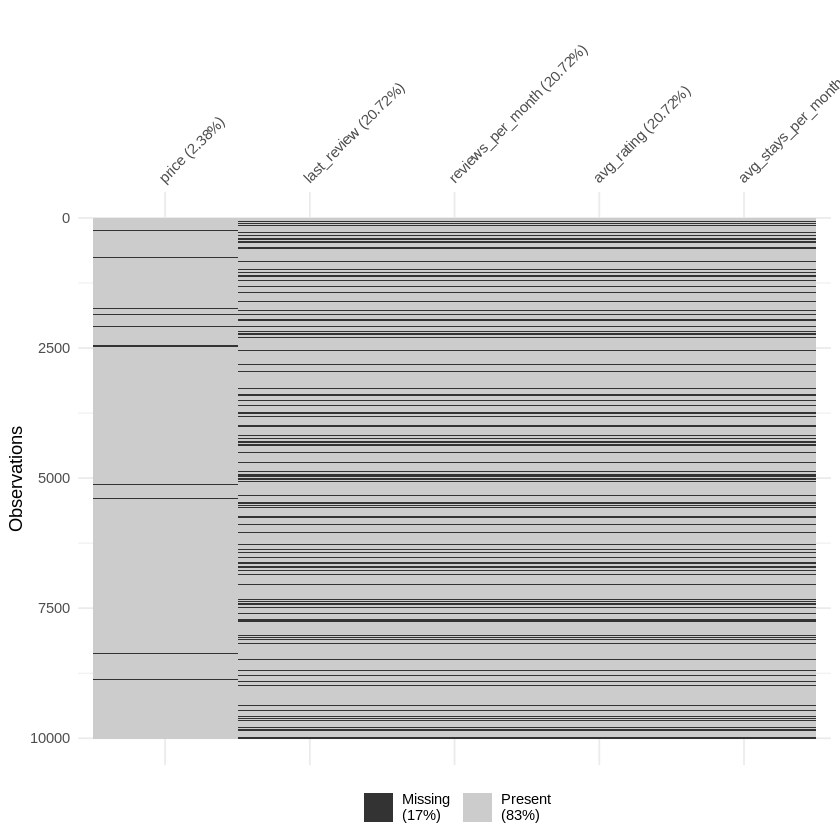

In [27]:
# Visualize missingness 

airbnb %>%
  # Focus only on columns with missing values
  select(price, last_review, reviews_per_month, avg_rating, avg_stays_per_month) %>%
  # Visualize missing data
  vis_miss()

It looks like missingness of `last_review`, `reviews_per_month`, `avg_rating`, and `avg_stays_per_month` are related. This suggests that these are places that have never been visited before (therefore have no ratings, reviews, or stays).

However, `price` is unrelated to the other columns, so we'll need to take a different approach for that.

In [28]:
# Sanity check that our hypothesis is correct
airbnb %>%
    filter(nb_reviews != 0,
           is.na(reviews_per_month))
airbnb %>%
    filter(nb_reviews != 0,
           is.na(avg_stays_per_month))

listing_id,description,host_id,host_name,room_type,price,nb_reviews,last_review,reviews_per_month,availability_365,avg_rating,avg_stays_per_month,pct_5_stars,listing_added,latitude,longitude,borough,nbhood
<dbl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<fct>,<fct>


listing_id,description,host_id,host_name,room_type,price,nb_reviews,last_review,reviews_per_month,availability_365,avg_rating,avg_stays_per_month,pct_5_stars,listing_added,latitude,longitude,borough,nbhood
<dbl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<fct>,<fct>


Now that we have a bit of evidence, we'll assume our hypothesis is true.
- We'll set any missing values in `reviews_per_month` or `avg_stays_per_month` to `0`.
    - Use `tidyr::replace_na()`
- We'll leave `last_review` and `avg_rating` as `NA`.
- We'll create a `logical` (`TRUE`/`FALSE`) column called `is_visited`, indicating whether or not the listing has been visited before.

In [29]:
# Replace missing data

airbnb <- airbnb %>%
    # Replace missing values in reviews_per_month or avg_stays_per_month with 0
    replace_na(list(reviews_per_month = 0, avg_stays_per_month = 0)) %>%
    # Create is_visited
    mutate(is_visited = !is.na(avg_rating))

ERROR: ignored

---
<center><h1><b>Q&A</b></h1></center>

---

**Treating the `price` column**

There are lots of ways we could do this
- Remove all rows with missing price values
- Fill in missing prices with the overall average price
- Fill in missing prices based on other columns like `borough` or `room_type`

**Let's examine the relationship between `room_type` and `price`.**

<img src='https://raw.githubusercontent.com/datacamp/cleaning-data-in-r-live-training/master/assets/boxplot.png' alt='Box plot diagram' width='350px;'>

Warning message:
“Removed 291 rows containing non-finite values (stat_boxplot).”


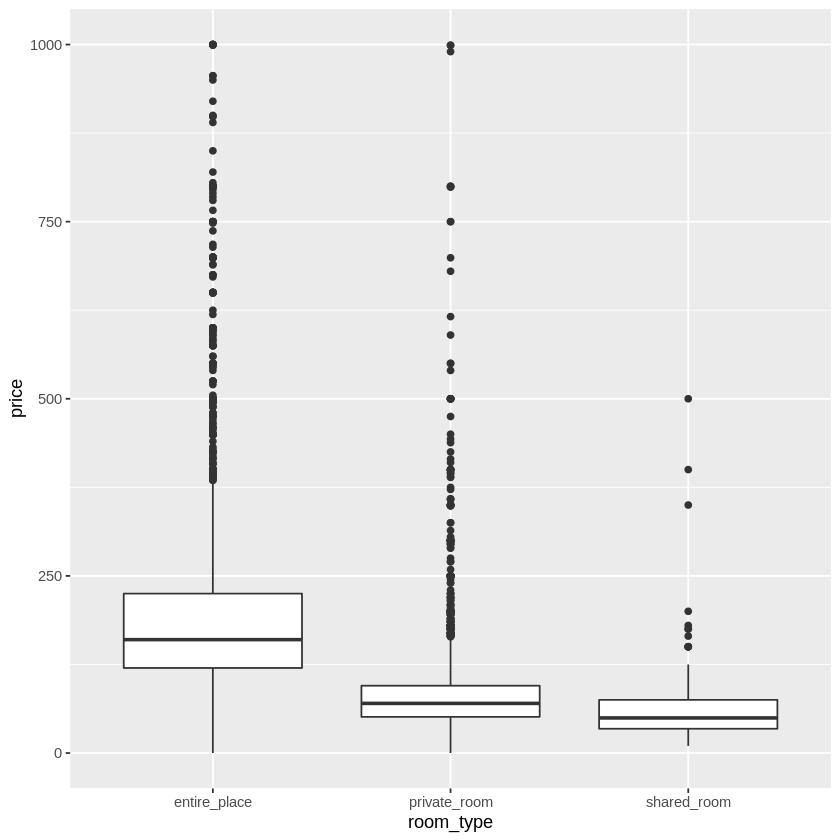

In [31]:
# Create a boxplot showing the distribution of price for each room_type
ggplot(airbnb, aes(x = room_type, y = price)) +
    geom_boxplot() +
    ylim(0, 1000)

We'll use *median* to summarize the `price` for each `room_type` since the distributions have a number of outliers, and median is more robust to outliers than mean.

We'll use `ifelse()`, which takes arguments of the form: `ifelse(condition, value if true, value if false)`.

In [32]:
# Use a grouped mutate to fill in missing prices with median of their room_type
airbnb %>%
    group_by(room_type) %>%
    mutate(price_filled = ifelse(is.na(price), median(price, na.rm = TRUE), price)) %>%
    # Look at the values we filled in to make sure it looks how we want
    filter(is.na(price)) %>%
    select(listing_id, description, room_type, price, price_filled)

listing_id,description,room_type,price,price_filled
<dbl>,<chr>,<fct>,<dbl>,<dbl>
7116071,30 Minutes to Manhattan / Sleeps 7,entire_place,NA,163
13395955,Adorable Prospect Heights 1 Bedroom,entire_place,NA,163
27903031,Prewar Gem in Middle of Everything!,private_room,NA,70
1700471,CHARM Rm HAMILTON HEIGHTS Harlem,private_room,NA,70
30235482,*Groovy Budget room for the traveler!,private_room,NA,70
518566,"Gorgeous, charming Upper East private room",private_room,NA,70
26889078,Staten Island Garden Apartment Near Ferry,entire_place,NA,163
29586573,1-Bedroom in Bushwick for 2 in shared apartment,private_room,NA,70
12753144,"Charming, Spacious 1 Bd-Great area!",entire_place,NA,163


In [0]:
# Overwrite price column in original data frame
airbnb <- airbnb %>%
    group_by(room_type) %>%
    mutate(price = ifelse(is.na(price), median(price, na.rm = TRUE), price)) %>%
    ungroup()

### **Duplicate data issues**


#### **Task 8:** Further investigate duplicate data points and decide how to handle them.

In [0]:
# Find duplicated listing_ids
duplicate_ids <- airbnb %>% 
    count(listing_id) %>% 
     filter(n > 1)

In [35]:
# Look at duplicated data
airbnb %>%
    filter(listing_id %in% duplicate_ids$listing_id) %>%
    arrange(listing_id)

listing_id,description,host_id,host_name,room_type,price,nb_reviews,last_review,reviews_per_month,availability_365,avg_rating,avg_stays_per_month,pct_5_stars,listing_added,latitude,longitude,borough,nbhood
<dbl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<fct>,<fct>
253806,Loft Suite @ The Box House Hotel,417504,The Box House Hotel,entire_place,199,43,2019-07-02,0.47,60,4.620238,51.6,0.8610863,2018-12-27,40.73652,-73.95236,Brooklyn,Greenpoint
253806,Loft Suite @ The Box House Hotel,417504,The Box House Hotel,entire_place,199,43,2019-07-02,0.47,60,4.620238,51.6,0.8610863,2018-12-27,40.73652,-73.95236,Brooklyn,Greenpoint
2044392,The heart of Williamsburg 2 bedroom,620218,Sarah,entire_place,250,0,NA,NA,0,NA,NA,NA,2018-05-24,40.71257,-73.96149,Brooklyn,Williamsburg
2044392,The heart of Williamsburg 2 bedroom,620218,Sarah,entire_place,245,0,NA,NA,0,NA,NA,NA,2018-08-09,40.71257,-73.96149,Brooklyn,Williamsburg
4244242,Best Bedroom in Bedstuy/Bushwick. Ensuite bathroom,22023014,BrooklynSleeps,private_room,70,110,2019-06-23,1.96,323,4.962314,132.0,0.8098820,2018-12-18,40.69496,-73.93949,Brooklyn,Bedford-Stuyvesant
4244242,Best Bedroom in Bedstuy/Bushwick. Ensuite bathroom,22023014,BrooklynSleeps,private_room,73,110,2019-06-23,1.96,323,4.962314,132.0,0.8098820,2018-12-18,40.69496,-73.93949,Brooklyn,Bedford-Stuyvesant
7319856,450ft Square Studio in Gramercy NY,11773680,Adam,entire_place,289,4,2016-05-22,0.09,225,3.903764,4.8,0.7563810,2015-11-17,40.73813,-73.98098,Manhattan,Kips Bay
7319856,450ft Square Studio in Gramercy NY,11773680,Adam,entire_place,280,4,2016-05-22,0.09,225,3.903764,4.8,0.7563810,2015-11-17,40.73813,-73.98098,Manhattan,Kips Bay
9078222,"Prospect Park 3 bdrm, Sleeps 8 (#2)",47219962,Babajide,entire_place,154,123,2019-07-01,2.74,263,3.466881,147.6,0.7381911,2018-12-26,40.66086,-73.96159,Brooklyn,Prospect-Lefferts Gardens


***Full duplicates***: All values match.
- To handle these, we can just remove all copies but one

***Partial duplicates***: Identifying values (like `listing_id`) match, but one or more of the others don't. Here, we have inconsistent values in `price`, `avg_rating`, and `listing_added`.
- We can remove them, pick a random copy to keep, or aggregate any inconsistent values. We'll aggregate using `mean()` for `price` and `avg_rating`, and `max()` for `listing_added`.

In [0]:
# Remove full duplicates
airbnb <- airbnb %>%
    distinct()

In [0]:
# Aggregate partial duplicates using grouped mutate
airbnb <- airbnb %>%
    group_by(listing_id) %>%
    # Overwrite columns with aggregations
    mutate(price = mean(price),
          avg_rating = mean(avg_rating),
          listing_added = max(listing_added)) %>%
    # Remove duplicates based only on listing_id
    distinct(listing_id, .keep_all = TRUE)

In [38]:
# Check that no duplicates remain
airbnb %>% 
    count(listing_id) %>% 
     filter(n > 1)

listing_id,n
<dbl>,<int>


### Take-home practice: **Sanity Checks**
*The data should be consistent both with itself, as well as with what we know about the world.*

- **Is the data consistent with itself?**
    - Are there any `last_review` dates before `listing_added` dates?
- **Is the data consistent with what we know about the world?**
    - Are there any `last_review` dates in the future?
    - Are there any `listing_added` dates in the future?



---
<center><h1><b>Q&A</b></h1></center>

---